In [4]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import QuantumSVM
from LSSVM import predict, lssvmMatrix, prepareLabels, accuracy

In [5]:
auxiliaryQubit = 0
shots = 100000 # 100000
gamma = 0.01 # regularization parameter
testSize = 0.2

In [6]:
svm = QuantumSVM(auxiliaryQubit=auxiliaryQubit, shots=shots)

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.04501022e+02  7.79837350e+00  6.62093022e-01
   2.31739575e-01 -5.82458282e+00  6.08099219e-02 -4.02365002e+00]
 [ 1.00000000e+00  7.79837350e+00  1.13526354e+02  9.36808102e-01
   4.53854003e-01 -1.01120401e+01  2.64495552e-01 -6.99645065e+00]
 [ 1.00000000e+00  6.62093022e-01  9.36808102e-01  1.03034739e+02
  -6.96993851e-01 -5.70578276e-01 -2.21358333e+00 -2.40470300e-01]
 [ 1.00000000e+00  2.31739575e-01  4.53854003e-01 -6.96993851e-01
   1.00193892e+02 -3.71119455e-01  5.56300620e-01 -2.94622830e-01]
 [ 1.00000000e+00 -5.82458282e+00 -1.01120401e+01 -5.70578276e-01
  -3.71119455e-01  1.07565235e+02 -2.95249727e-01  5.24107601e+00]
 [ 1.00000000e+00  6.08099219e-02  2.64495552e-01 -2.21358333e+00
   5.56300620e-01 -2.95249727e-01  1.01682486e+02 -3.20247137e-01]
 [ 1.00000000e+00 -4.02365002e+00 -6.99645065e+00 -2.4

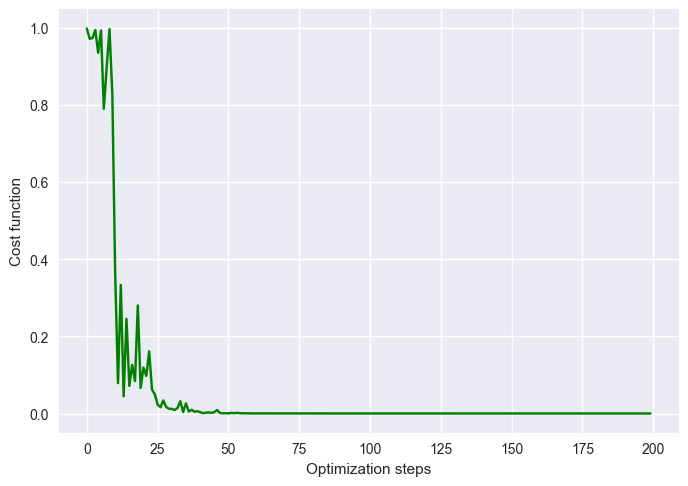

In [8]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = np.array([X_train[i] for i in subsetIndices])
ySubset = np.array([y_train[i] for i in subsetIndices])

lssvm_matrix = lssvmMatrix(xSubset, gamma, "linearKernel")
yVector = prepareLabels(ySubset)

print("LS-SVM Matrix:", lssvm_matrix)

pauliOp = SparsePauliOp.from_operator(lssvm_matrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = svm.getMatrixCoeffitients(pauliOp)
print(coefficientSet)

out_f = svm.minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=yVector,
    quantumSimulation=False,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = svm.ansatzTest(circ, out_f)

svm.getApproximationValue(lssvm_matrix, yVector, o)
svm.plotCost()

Statevector([-0.01162803+0.j,  0.34519142+0.j, -0.00705819+0.j,
             -0.54271986+0.j, -0.01298276+0.j, -0.51100454+0.j,
              0.04708095+0.j,  0.56798081+0.j],
            dims=(2, 2, 2))
[ -0.11351218+0.j  36.33774087+0.j   2.57059833+0.j -55.64887395+0.j
  -0.80886316+0.j -53.63976279+0.j   5.95791691+0.j  54.95479946+0.j]
0.051988161861787174


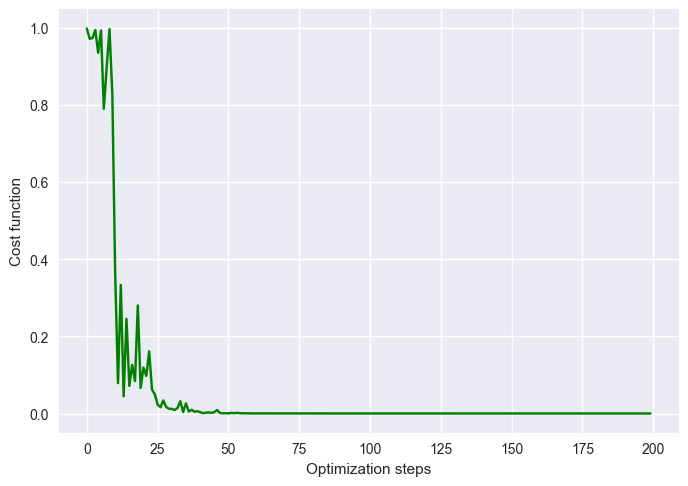

In [9]:
print(o)
print(lssvm_matrix.dot(o))

svm.getApproximationValue(lssvm_matrix, yVector, o)
svm.plotCost()

In [11]:
subsetIndicesTest = np.random.choice(
    np.arange(X_test.shape[0]), subsetSize, replace=False
)
xTestSubset = []
yTestSubset = []
for i in subsetIndicesTest:
    xTestSubset.append(X_test[i])
    yTestSubset.append(y_test[i])

xTestSubset = np.array(xTestSubset)
yTestSubset = np.array(yTestSubset)
print(o)
b = o[0]
print(b)
w = []
for i in range(len(o)):
    if i != 0:
        w.append(o[i])
print(w)
predictions = predict(xSubset, xTestSubset, w, b)
print("Predictions:", predictions)
print("Accuracy:", accuracy(yTestSubset, predictions))

Statevector([-0.01162803+0.j,  0.34519142+0.j, -0.00705819+0.j,
             -0.54271986+0.j, -0.01298276+0.j, -0.51100454+0.j,
              0.04708095+0.j,  0.56798081+0.j],
            dims=(2, 2, 2))
(-0.0116280277+0j)
[(0.3451914158+0j), (-0.0070581851+0j), (-0.5427198613+0j), (-0.0129827619+0j), (-0.5110045422+0j), (0.0470809464+0j), (0.5679808093+0j)]
Predictions: [ 1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j]
Accuracy: 0.7142857142857143
